In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.integrate import odeint
from mpl_toolkits import mplot3d

%config InlineBackend.figure_format = 'retina'

In [2]:
class Synapse:
    def __init__(self, neuron, t_range):
        self.neuron = neuron
        self.t_range = t_range
        self.spikes_times = np.cumsum(self.neuron['dist'](t_max))
        L = 0
        probs = []

        for t in self.t_range:
            L = np.clip(L - self.neuron['L_out'] + (t in self.spikes_times)*self.neuron['L_in'] , 0, self.neuron['V'])
            l = L / self.neuron['V']
            P_o = (l / self.neuron['K_d']) / (1 + l / self.neuron['K_d'])
            probs.append(P_o)
        self.I_dict = dict(zip(self.t_range, probs))
        
    def I(self, t):
        return self.neuron['N']* self.neuron['gamma'] * self.I_dict[int(t)] * 1e6 * 1e-9

In [3]:
class Hodgkin_Huxley_Model:
    def __init__(self, t_range,
                 g=(.3, 36, 120),#mS/cm^2
                 E=(-54.387, -77, 50),#mV
                 init_cond=(-65, 0.05, 0.6, 0.32, 0, 0, 0, 0),
                 C_m=1):
        
        self.A = Synapse(A, t_range)
        self.B = Synapse(B, t_range)
        
        self.t_range = t_range
        self.g_L, self.g_K, self.g_Na = g
        self.E_L, self.E_K, self.E_Na = E
        self.init_cond = init_cond
        self.C_m = C_m

    @staticmethod
    def alpha_n(V_):
        return .01 * (V_ + 55)/(1 - np.exp(-.1 * (V_ + 55)))
    @staticmethod
    def beta_n(V_):
        return .125 * np.exp(-.0125 * (V_ + 65))
    @staticmethod
    def alpha_m(V_):
        return .1 * (V_ + 40)/(1 - np.exp(-.1 * (V_ + 40)))
    @staticmethod
    def beta_m(V_):
        return 4 * np.exp(-.0556 * (V_ + 65))
    @staticmethod
    def alpha_h(V_):
        return .07 * np.exp(-.05 * (V_ + 65))
    @staticmethod
    def beta_h(V_):
        return 1 / (1 + np.exp(-.1 * (V_ + 35))) 
    @staticmethod
    def der(V_, alpha, beta, par):
        return alpha(V_) * (1 - par) - beta(V_) * par
    
    def dV_dt(self, V_, n_, m_, h_, I_A, I_B):
        return (-1/self.C_m) * (self.g_K * n_**4 * (V_ - self.E_K)
                           + self.g_Na * m_**3 * h_ * (V_ - self.E_Na)
                           + I_A + I_B)
    
    def derivatives(self, variabels, t):
        V, n, m, h = variabels[:4]
        I_A = (V - 55) * self.A.I(t)
        I_B = (V + 65)*self.B.I(t)
        I_K = self.g_K * n**4 * (V - self.E_K)
        I_Na = self.g_Na * m**3 * h * (V - self.E_Na)
        return [self.dV_dt(V, n, m, h, I_A, I_B), 
                self.der(V, self.alpha_n, self.beta_n, n),
                self.der(V, self.alpha_m, self.beta_m, m),
                self.der(V, self.alpha_h, self.beta_h, h), 
                I_A, I_B, I_K, I_Na]
    
    def solve_system(self):
        solution = odeint(self.derivatives, self.init_cond, self.t_range)
        return solution
    

In [27]:
def visulize_simulation(solution, t, N=int(6e4), lw=0.1):
    solution = solution[:N]
    t = t[:N]
    cmap = plt.get_cmap("tab10")
    fig, axs = plt.subplots(figsize=(20, 20))
    plt.suptitle('The dynamics of V, m, h, n in the Hodgkin-Huxley during the simulation', fontsize=16)


    ax1 = plt.subplot(611)
    ax1.plot(t, solution[:,0], lw=lw)
    ax1.set_ylabel("V[mV]", fontsize=16)
    
    ax2 = plt.subplot(612, sharex=ax1)
    for i, lbl in zip([1, 2, 3], ["n", "m", "h"]):
        ax2.plot(t, solution[:, i], label=lbl, color=cmap(i), lw=lw)
    ax2.set_ylabel("act / inact", fontsize=16)
    ax2.legend(loc=1)
    
    ax3 = plt.subplot(613, sharex=ax1)
    I_t = (solution[:, 4] + solution[:, 5])[:]
    ax3.plot(t, I_t)
    ax3.set_ylabel("I syn[nA]", fontsize=16)
    
    ax4 = plt.subplot(614, sharex=ax1)
    I_t = solution[:, 5][:]
    ax4.plot(t, I_t)
    ax4.set_ylabel("I Cl [nA]", fontsize=16)
    
    ax5 = plt.subplot(615, sharex=ax1)
    I_t = solution[:, 6][:]
    ax5.plot(t, I_t)
    ax5.set_ylabel("I Ka [nA]", fontsize=16)
    
    ax6 = plt.subplot(616, sharex=ax1)
    I_t = (solution[:, 5] + solution[:, 7])[:]
    ax6.plot(t, I_t)
    ax6.set_ylabel("I Na [nA]", fontsize=16)
    ax6.set_xlabel("Time, ms", fontsize=16)
    
    
    fig = plt.figure(figsize=(20, 5))
    plt.suptitle('The phase spaces', fontsize=16)
    for i, lbl in zip([1, 2, 3], ["n", "m", "h"]):
        ax = plt.subplot(1, 3, i)
        ax.plot(solution[:, 0], solution[:, i], color=cmap(i), lw=lw)
        ax.set_xlabel("V(t) [mV]", fontsize=16)
        ax.set_ylabel(f"{lbl}(t)", fontsize=16)
        
    fig = plt.figure(figsize=(20, 8))
    for i, lbl in zip([1, 2, 3], ["n", "m", "h"]):
        ax = fig.add_subplot(1, 3, i, projection='3d')
        ax.plot3D(t, solution[:, 0], solution[:, i], color=cmap(i), lw=lw)
        ax.set_xlabel("t [mS]", fontsize=16)
        ax.set_ylabel("V(t) [mV]", fontsize=16)
        ax.set_zlabel(f"{lbl}(t)", fontsize=16)

def visulize_burst(hz, th=10):
    plt.figure(figsize=(20, 5))
    plt.plot(hz)
    plt.xlabel('Time, s', fontsize=16)
    plt.ylabel('Hz', fontsize=16)
    plt.hlines(th, 0, 60, 'r', '--', label='Threshold frequency')
    plt.show()
    
def to_HZ(sol):
    hz = []
    for sec in np.split(sol[:, 0], 60):
        spikes, i = 0, 0
        while i < 999:
            if sec[i] > 0 and sec[i+1] < 0:
                spikes+=1
            i+=1
        hz.append(spikes)
    return hz

In [15]:
.shape

(60000,)

### Задание 1 - 3:

Эксперимент длится 60 с

Котенок погибает если:
* пирамидный нейрон не спайкается более 10 секунд подряд
* пирамидный нейрон будет спайкаться более 20 секунд подряд с частотой 10Гц
* частота спайков превысит 16Гц на протяжении более 5 секунд

Были подобраны следующие параметры чтобы котенок выжил в результате эксперимента: 

In [6]:
A = {'L_in':int(1e3), 'L_out':int(4e2), 'K_d': 1e9/128, 'gamma': 8, 'V_eq': -65, 'dist': lambda size: np.random.poisson(100, size=size), 'V': int(1e3), 'N': int(3e9)}
B = {'L_in':int(1e3), 'L_out':int(1e2), 'K_d': 1e9/500, 'gamma': 10, 'V_eq': 55, 'dist': lambda size: np.random.randint(300, size=size), 'V': int(1e3), 'N': int(1e9)}

t_max= 60*int(1e3)
t = np.arange(0, t_max, 1)

XXX = Hodgkin_Huxley_Model(t)
solution = XXX.solve_system()

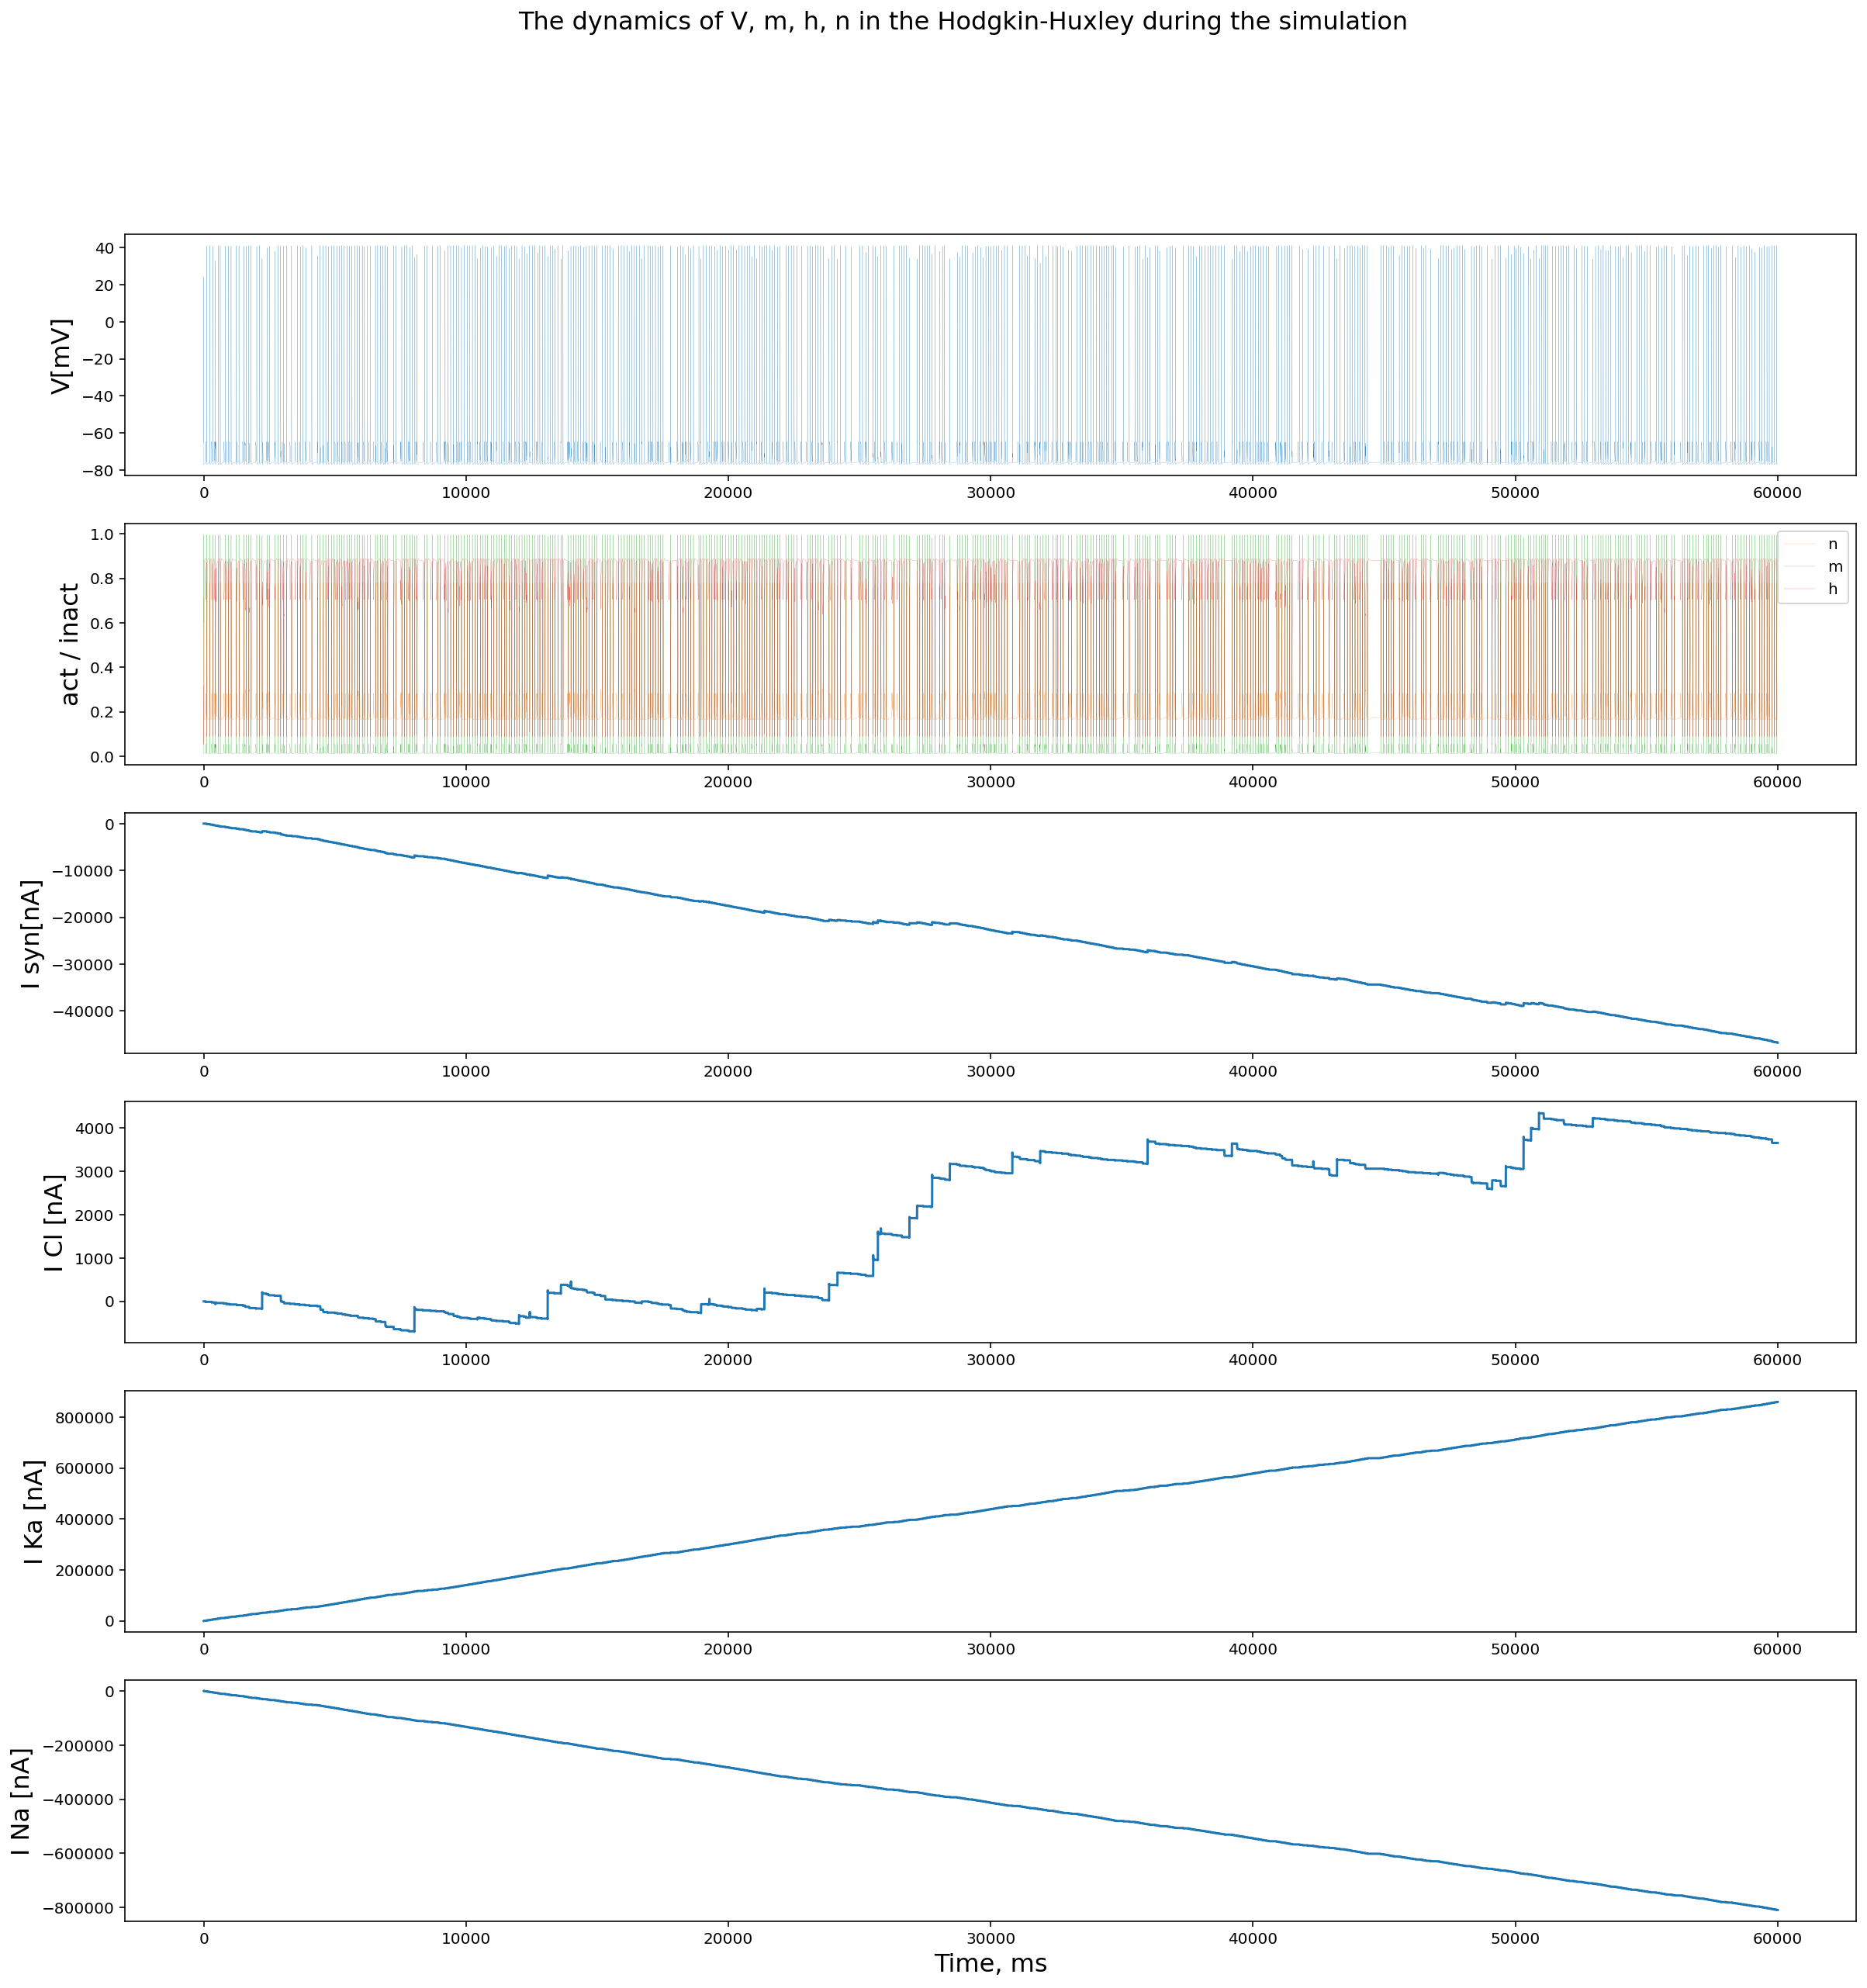

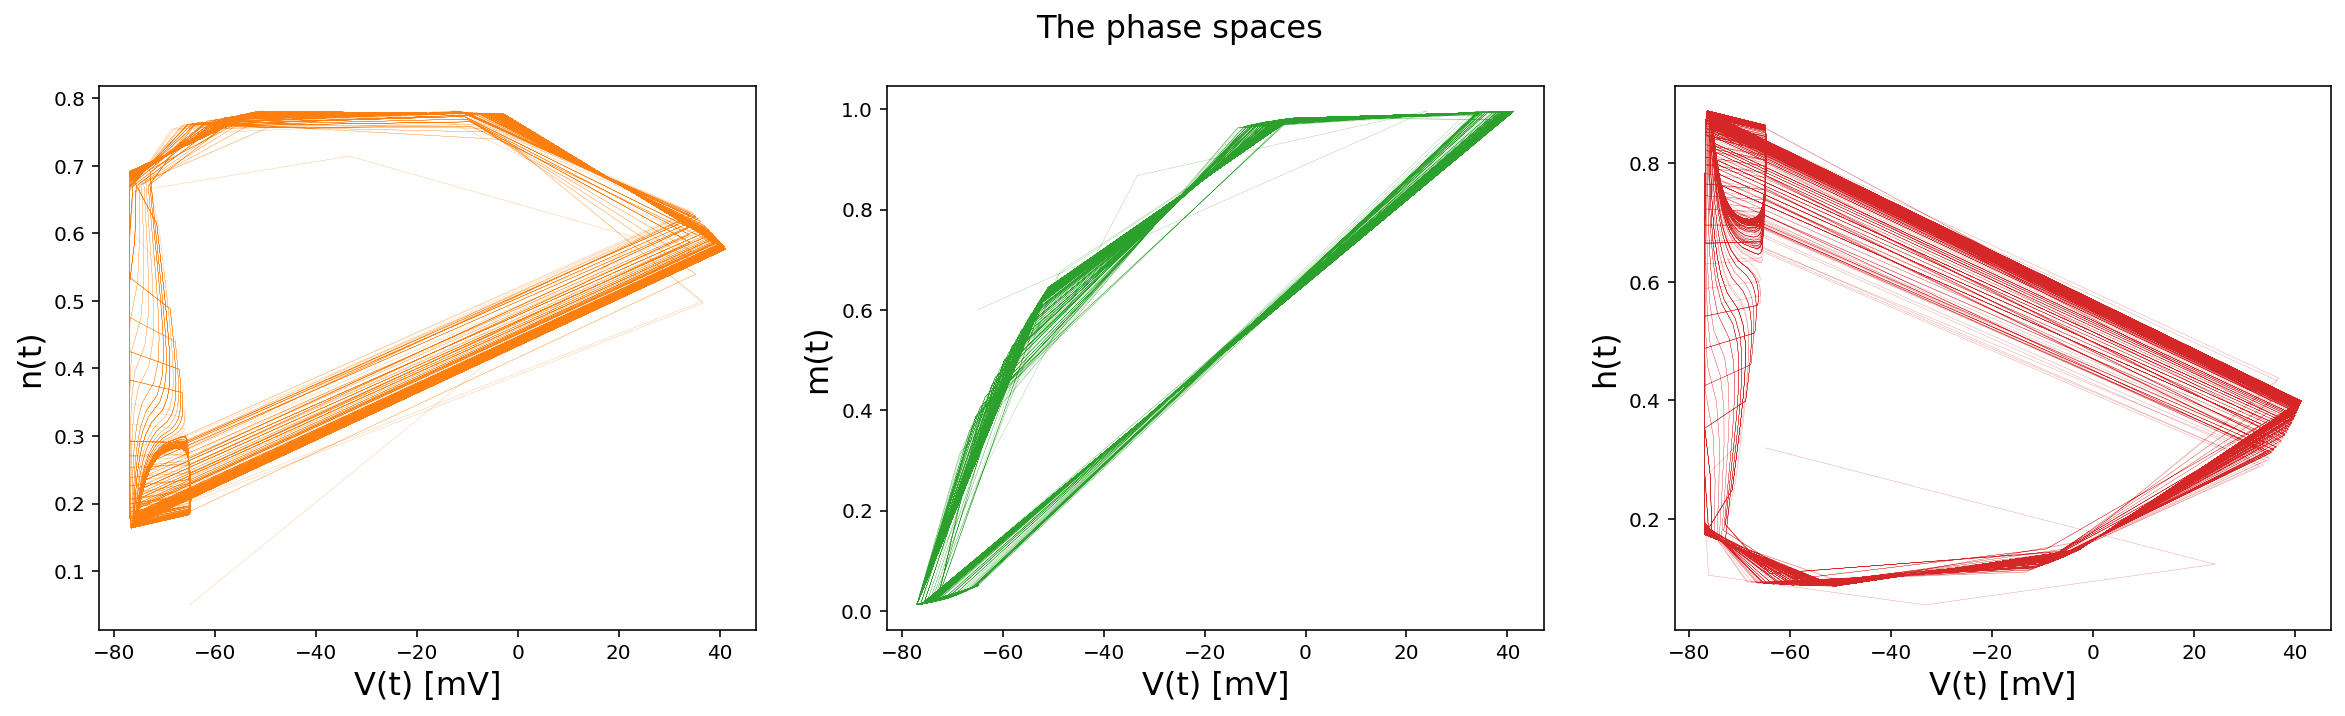

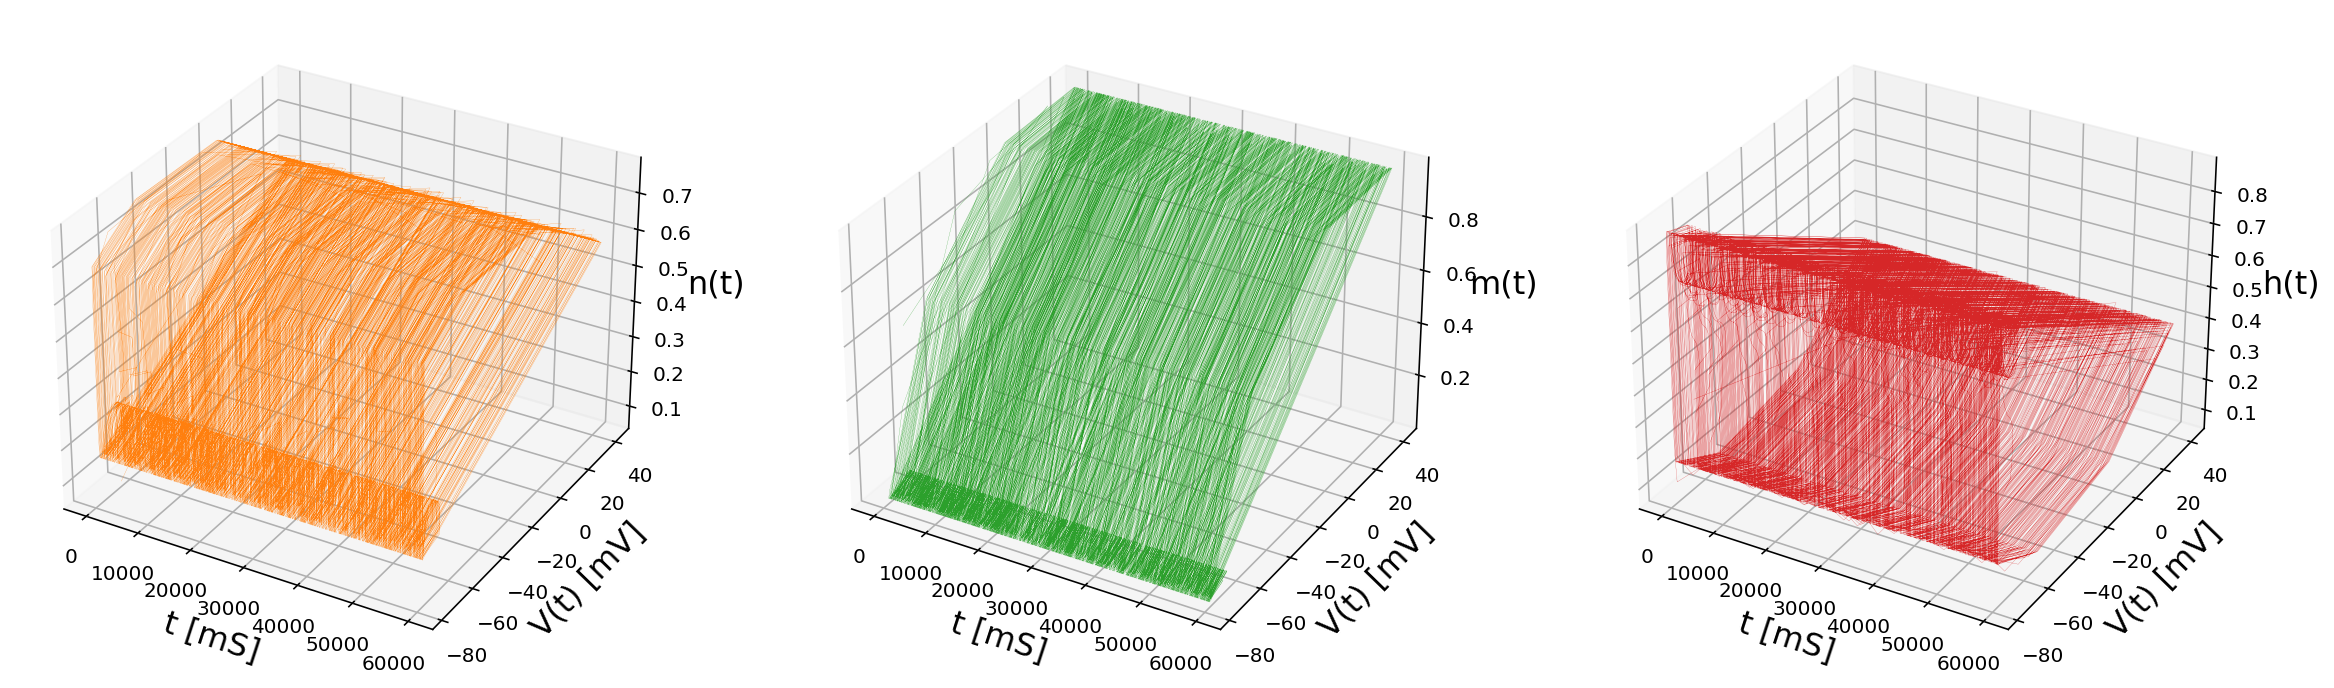

In [28]:
visulize_simulation(solution, t)

При данных параметрах:
* 1) Котенок выживает (УРА!)
* 2) спайки не реже 1 раза в 500мс
* 3) Также если посмотреть на частоты, видим что не менее 5 раз за время эксперимента частота достигает значения в 10 ГЦ, что свидетельствует о бёрстинговой активности нейрона, требуемой в 3-ем задании.

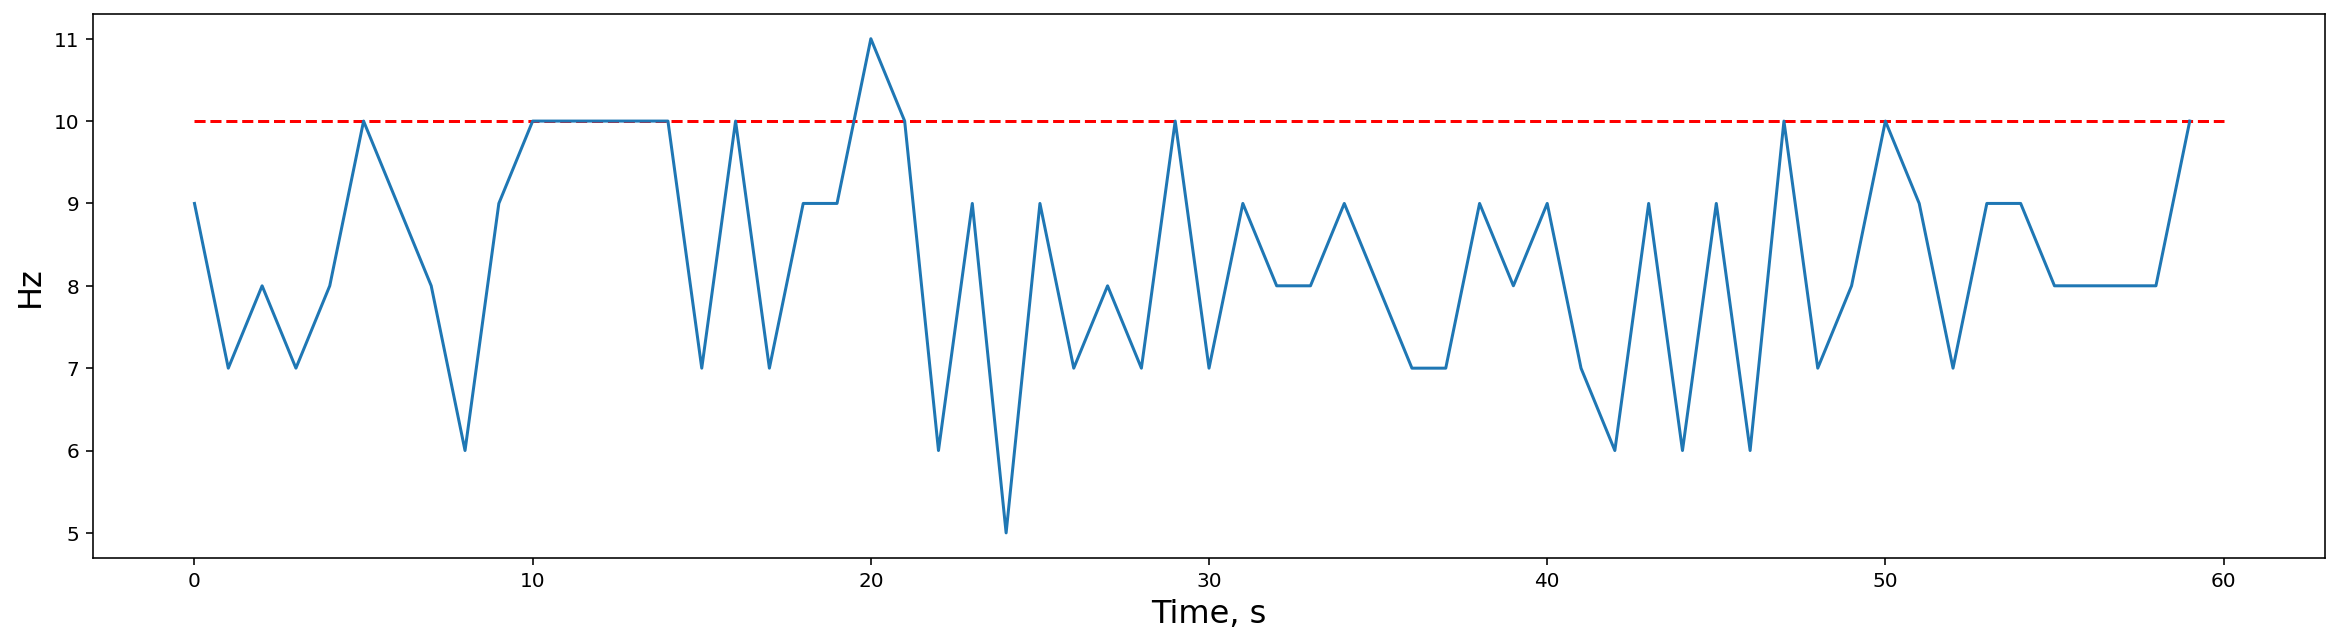

In [9]:
hz = to_HZ(solution)
visulize_burst(hz, th=10)

Чтобы делать какие-то выводы посмотрим на меньший промежуток времени:

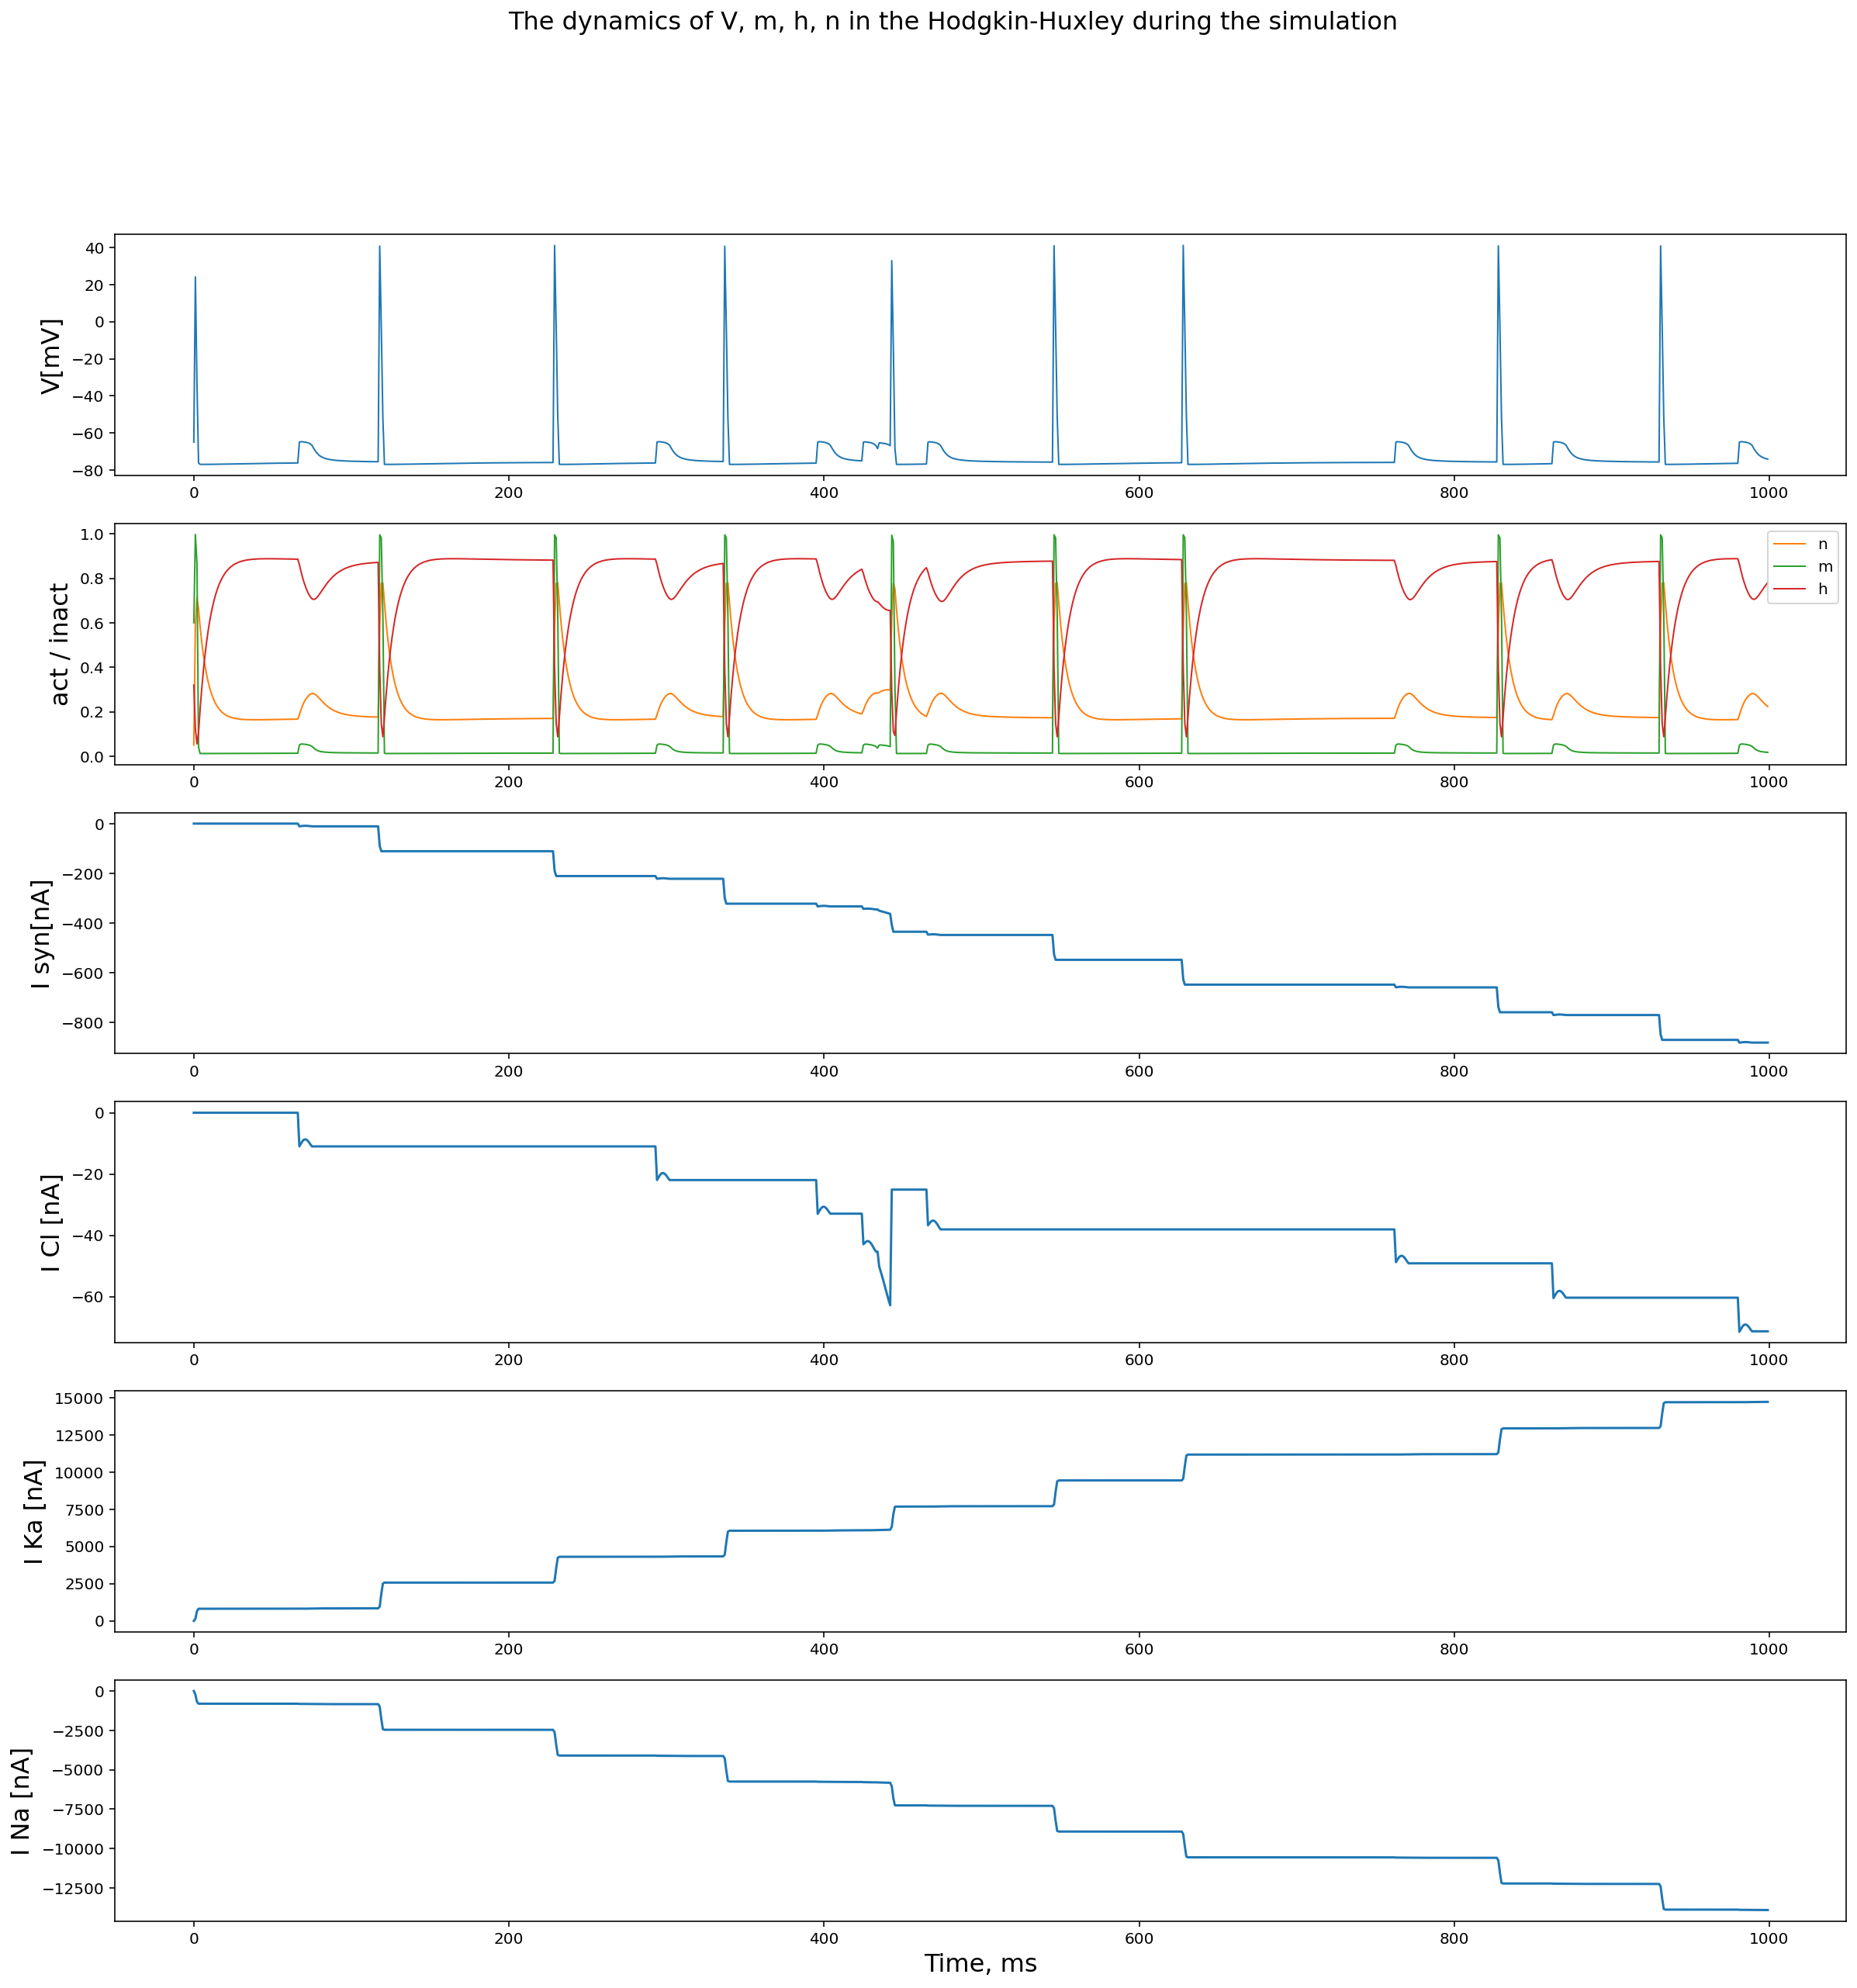

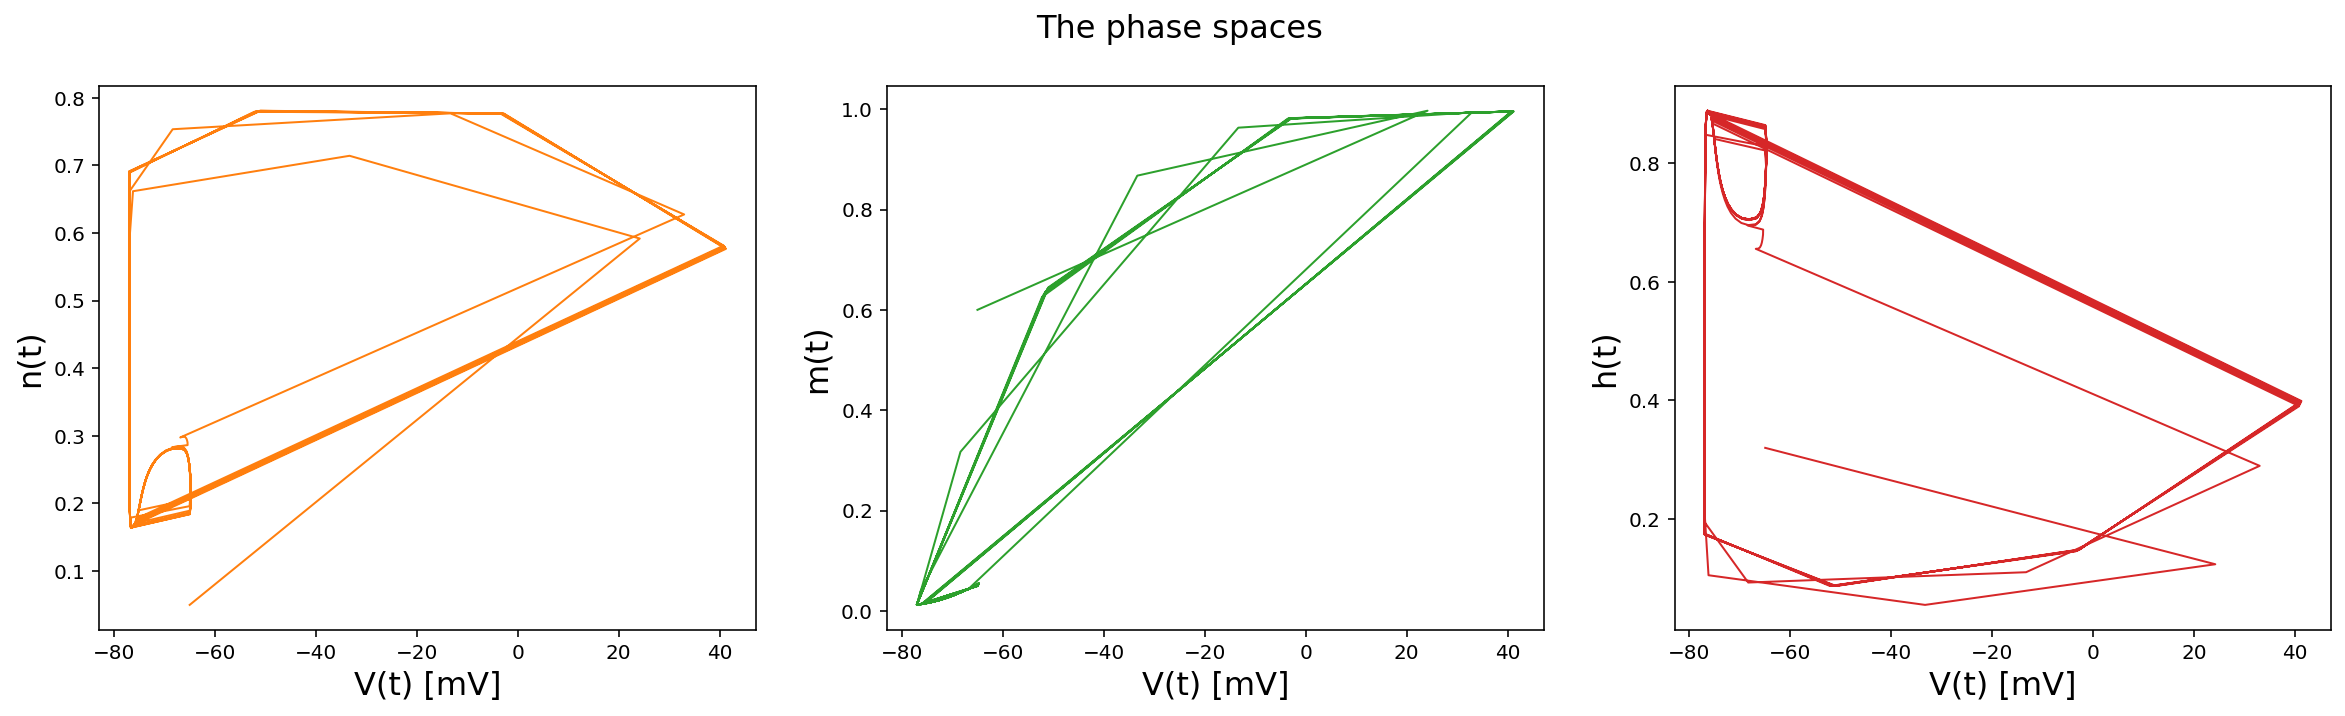

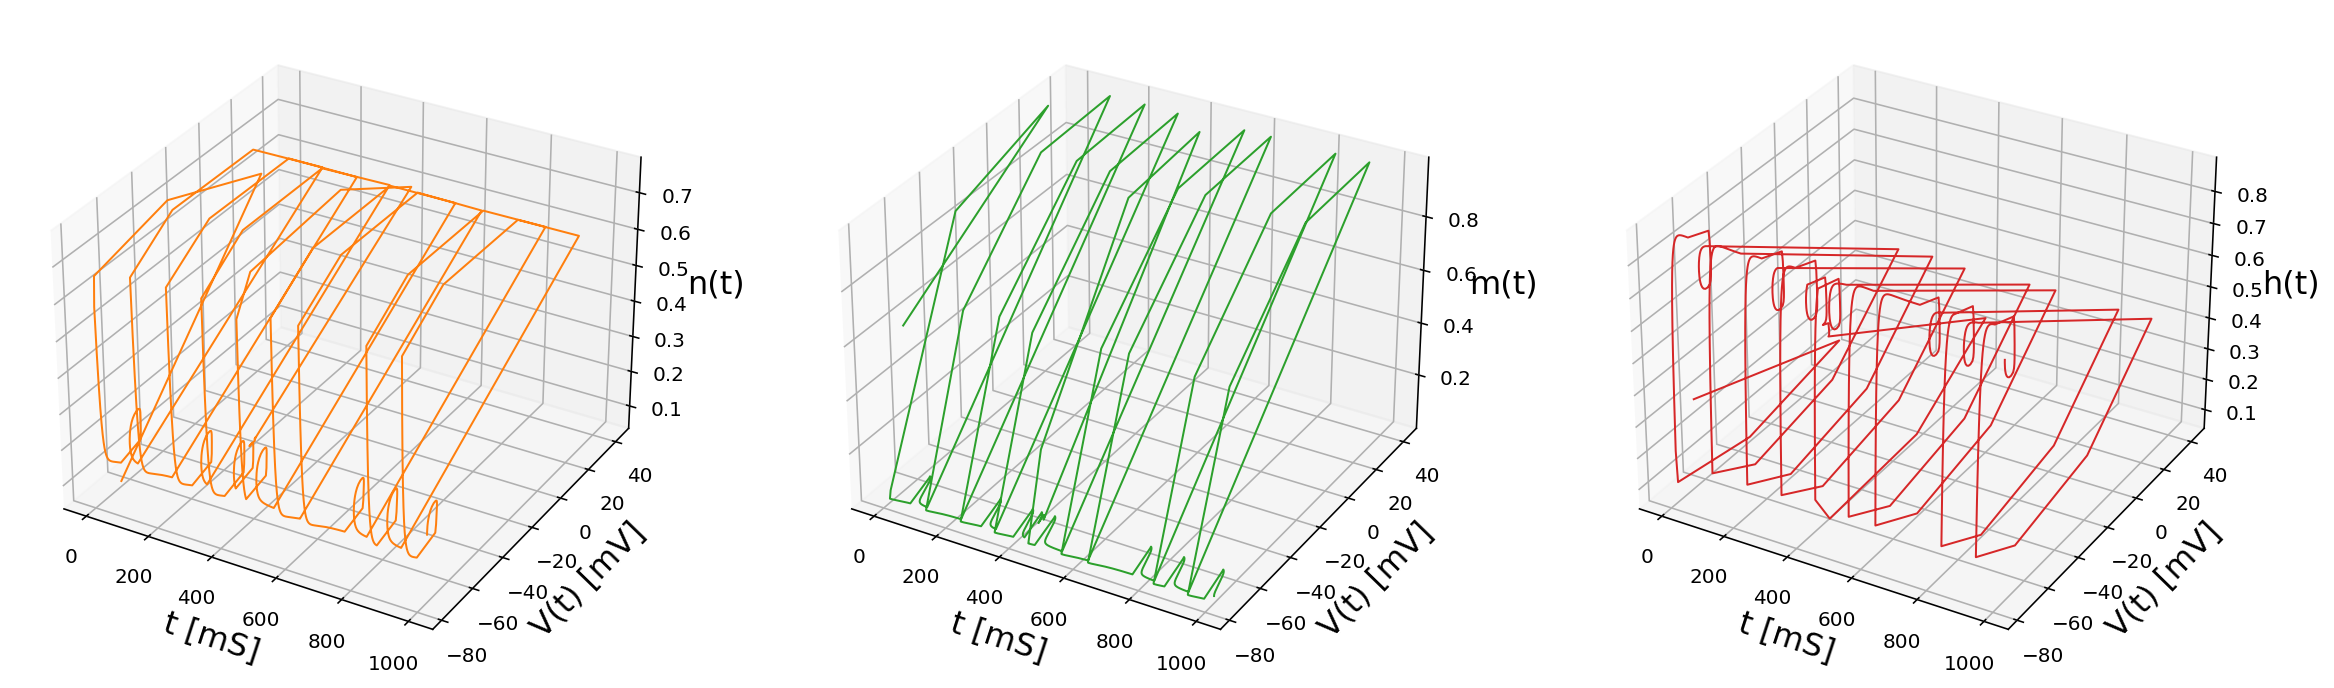

In [31]:
visulize_simulation(solution, t, N=int(1e3), lw=1)

Проанализируем графики симуляции:
* 1.1 Каждый раз при увеличении абсолютного значения силы тока в синапсах, происходит спайк. 
* 1.2 Частота спайков практически полностью повторяет постепенное увеличение тока в синапсе А.
* 2.1 По фазовым портретам симуляции видно, что существуют предельные циклы в те моменты когда наблюдаются спайки. 
* 3.1 Токи калия и натрия дают примерно одинаковый вклад по абсолютным значениям, в то время как значения силы тока хлор существенно меньше. Однако он наиболее динамичный по сравнению с остальными: ток натрия и хлора равномерно увеличивается по времени симуляции. 

### Задание 4:

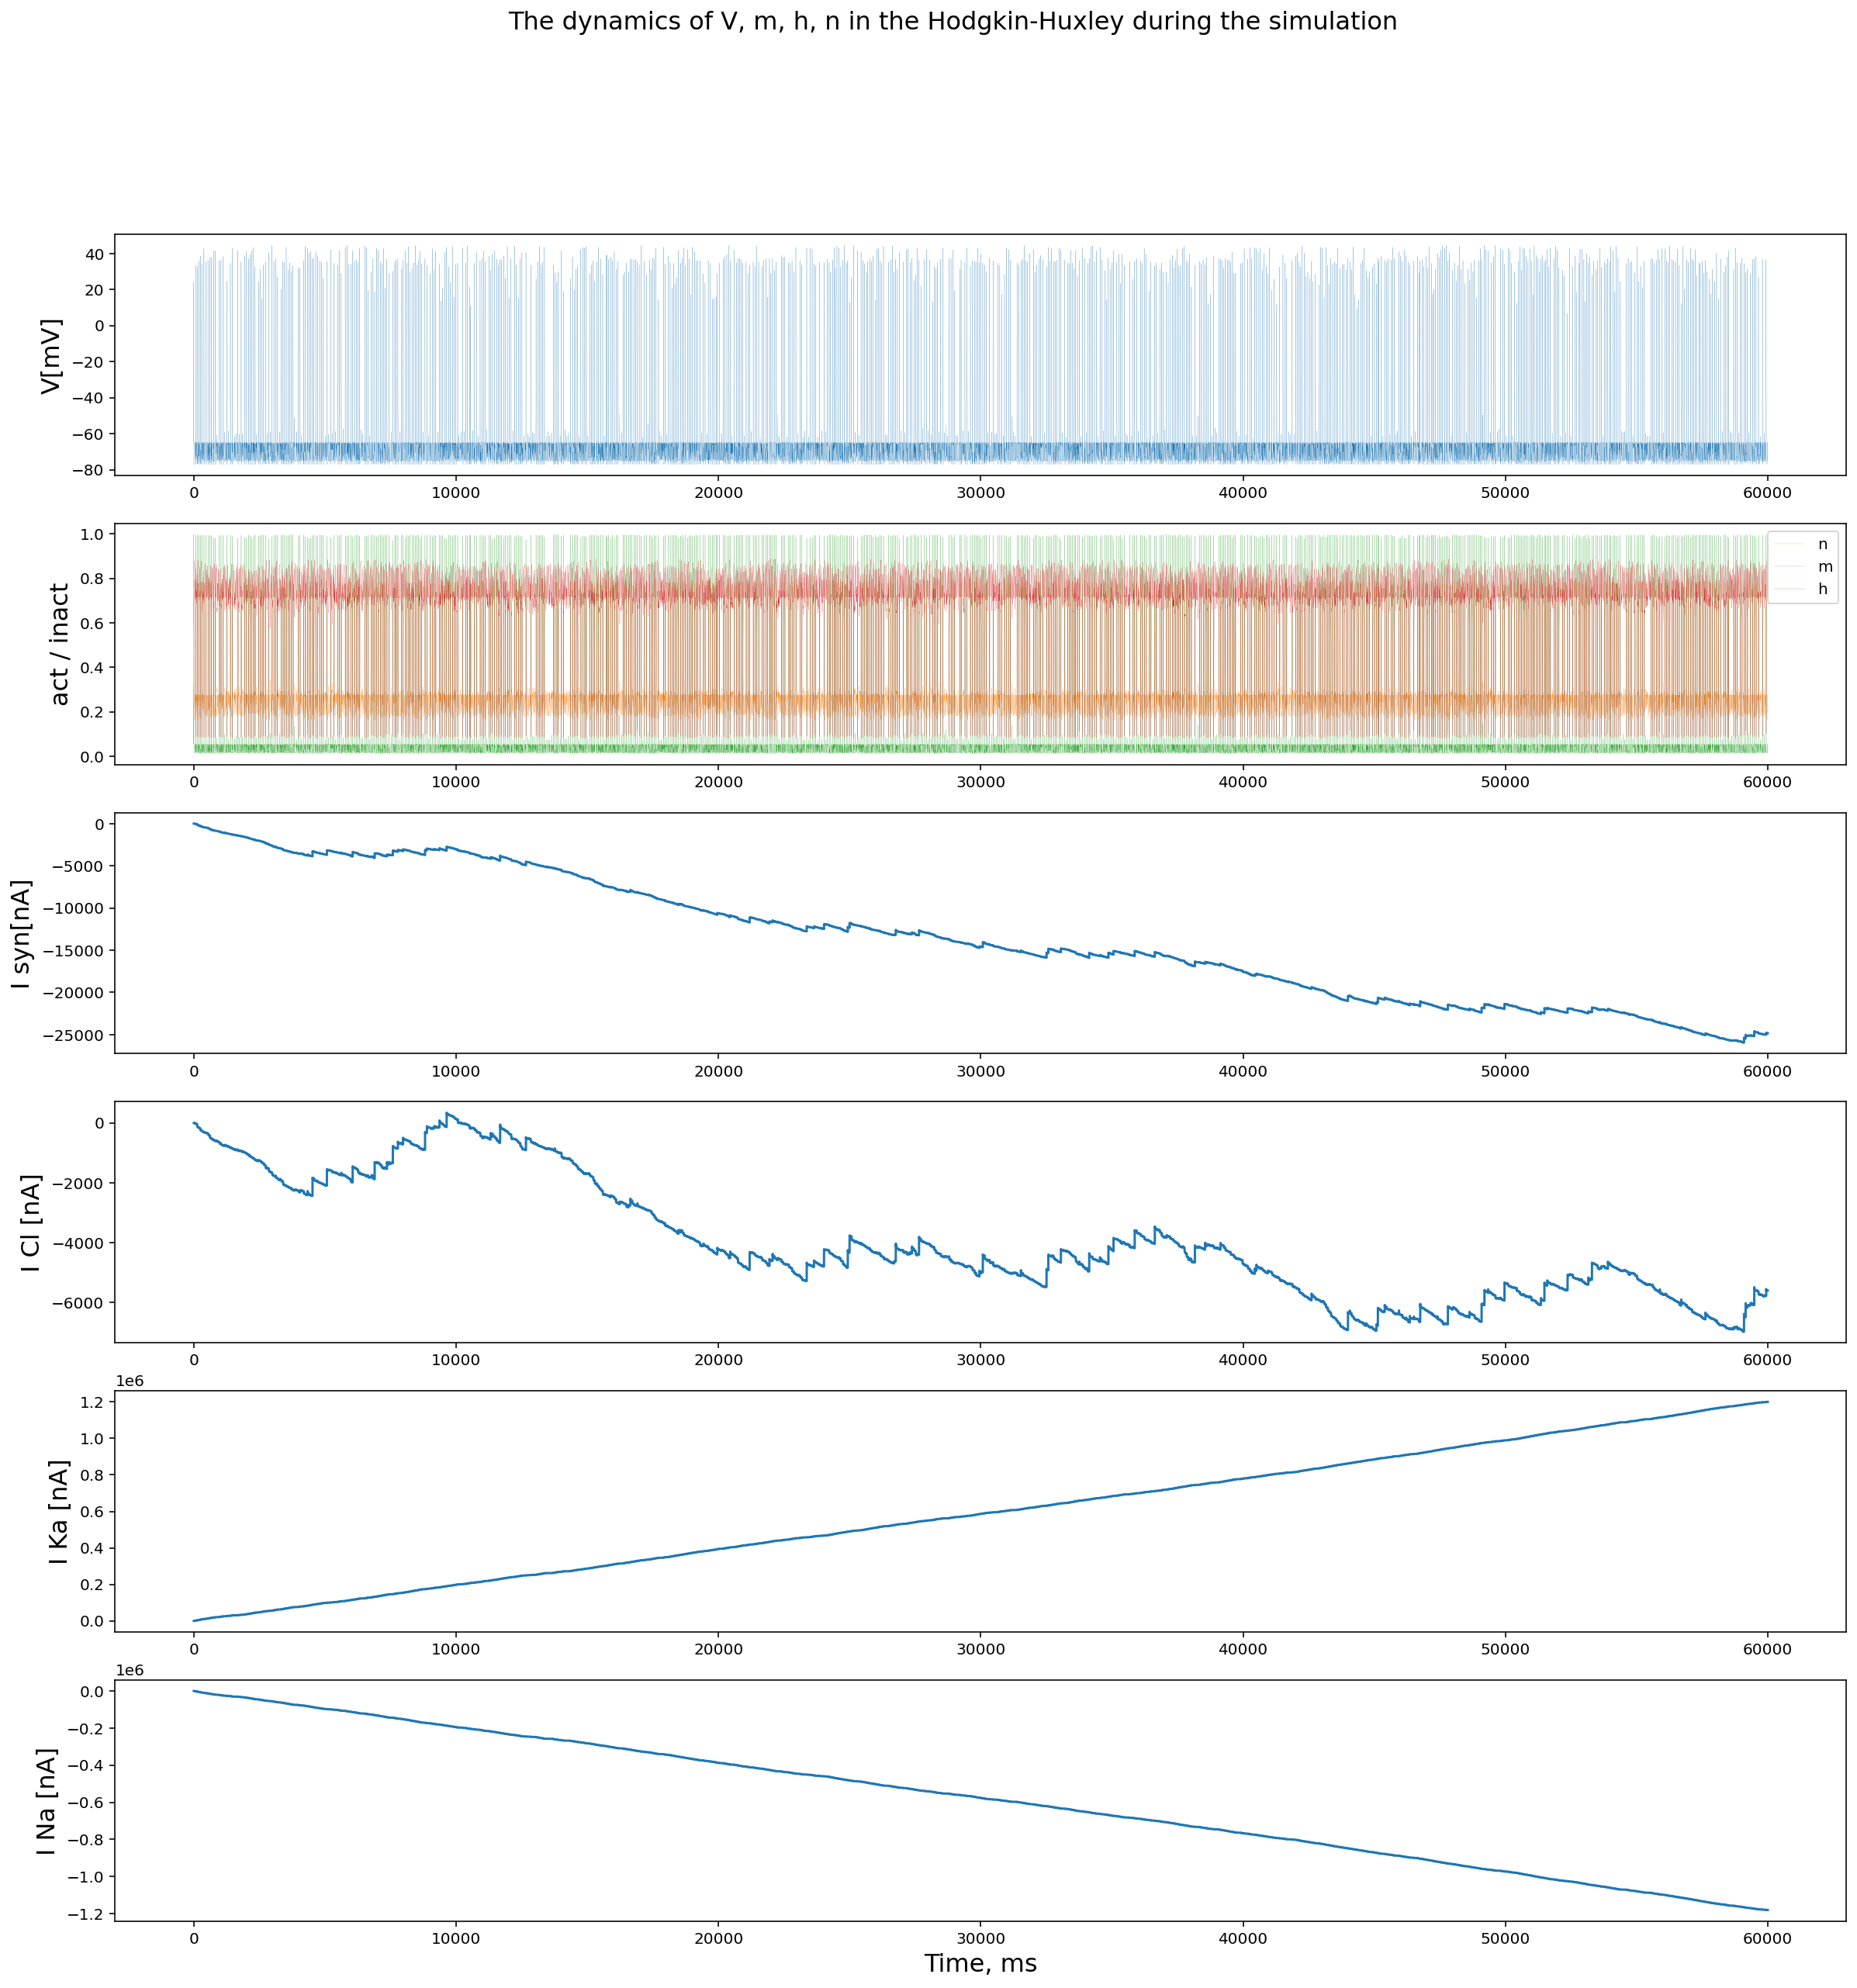

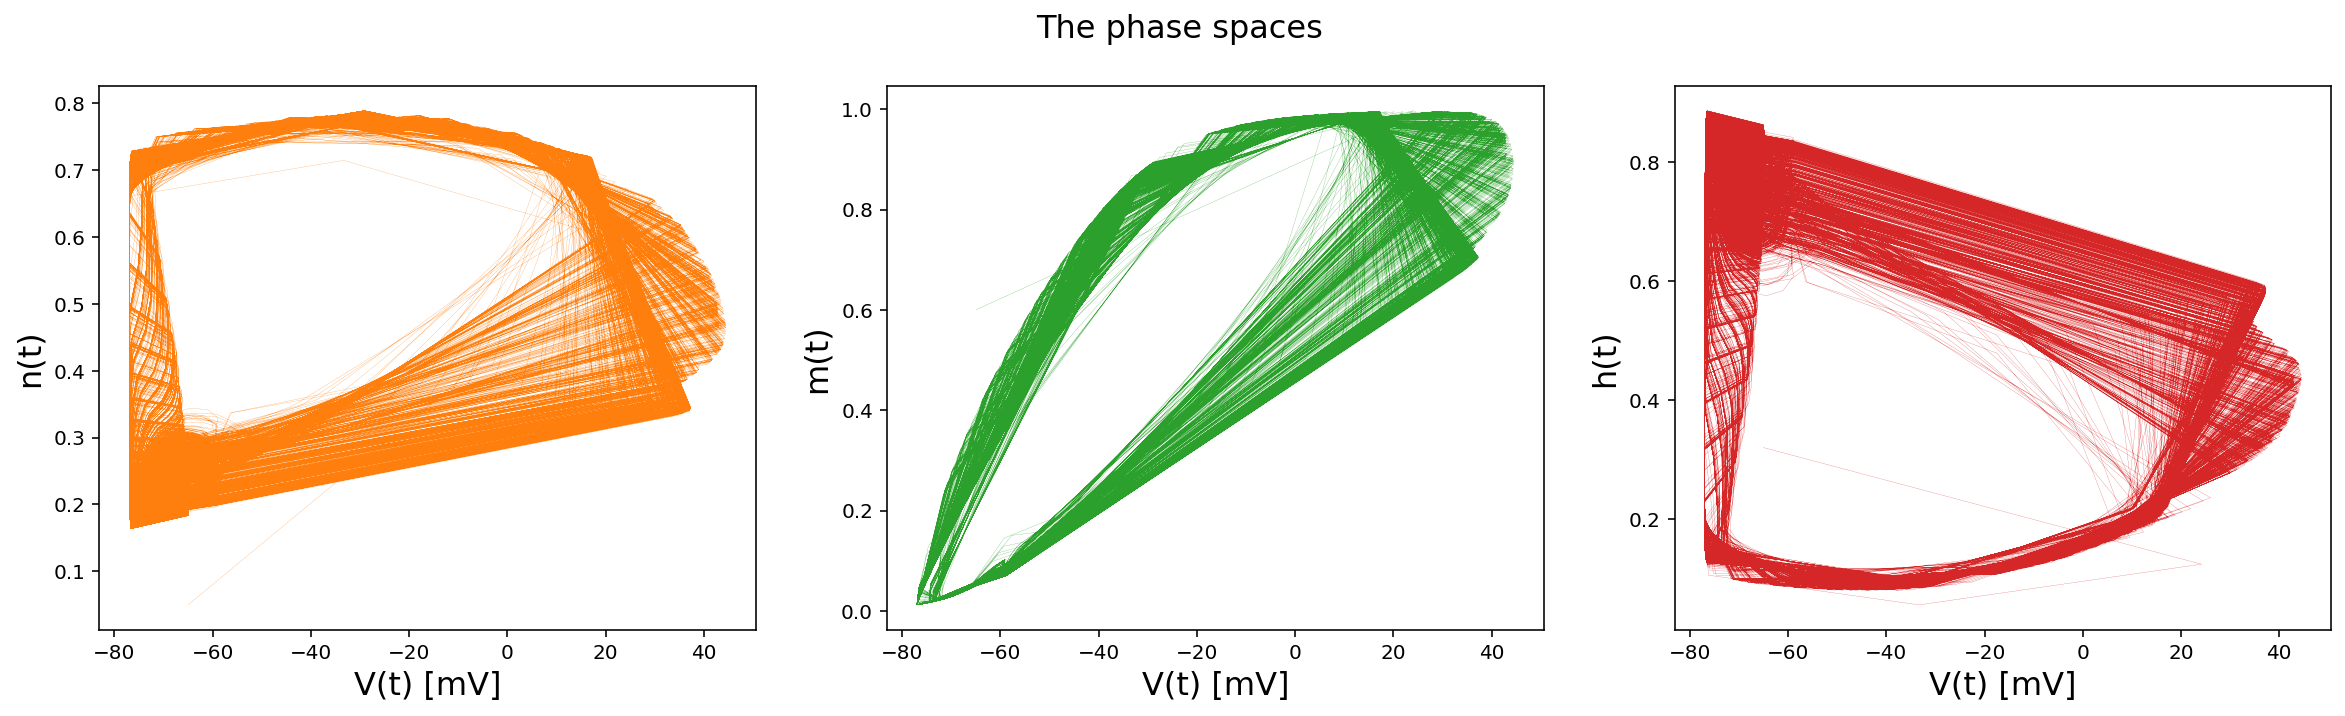

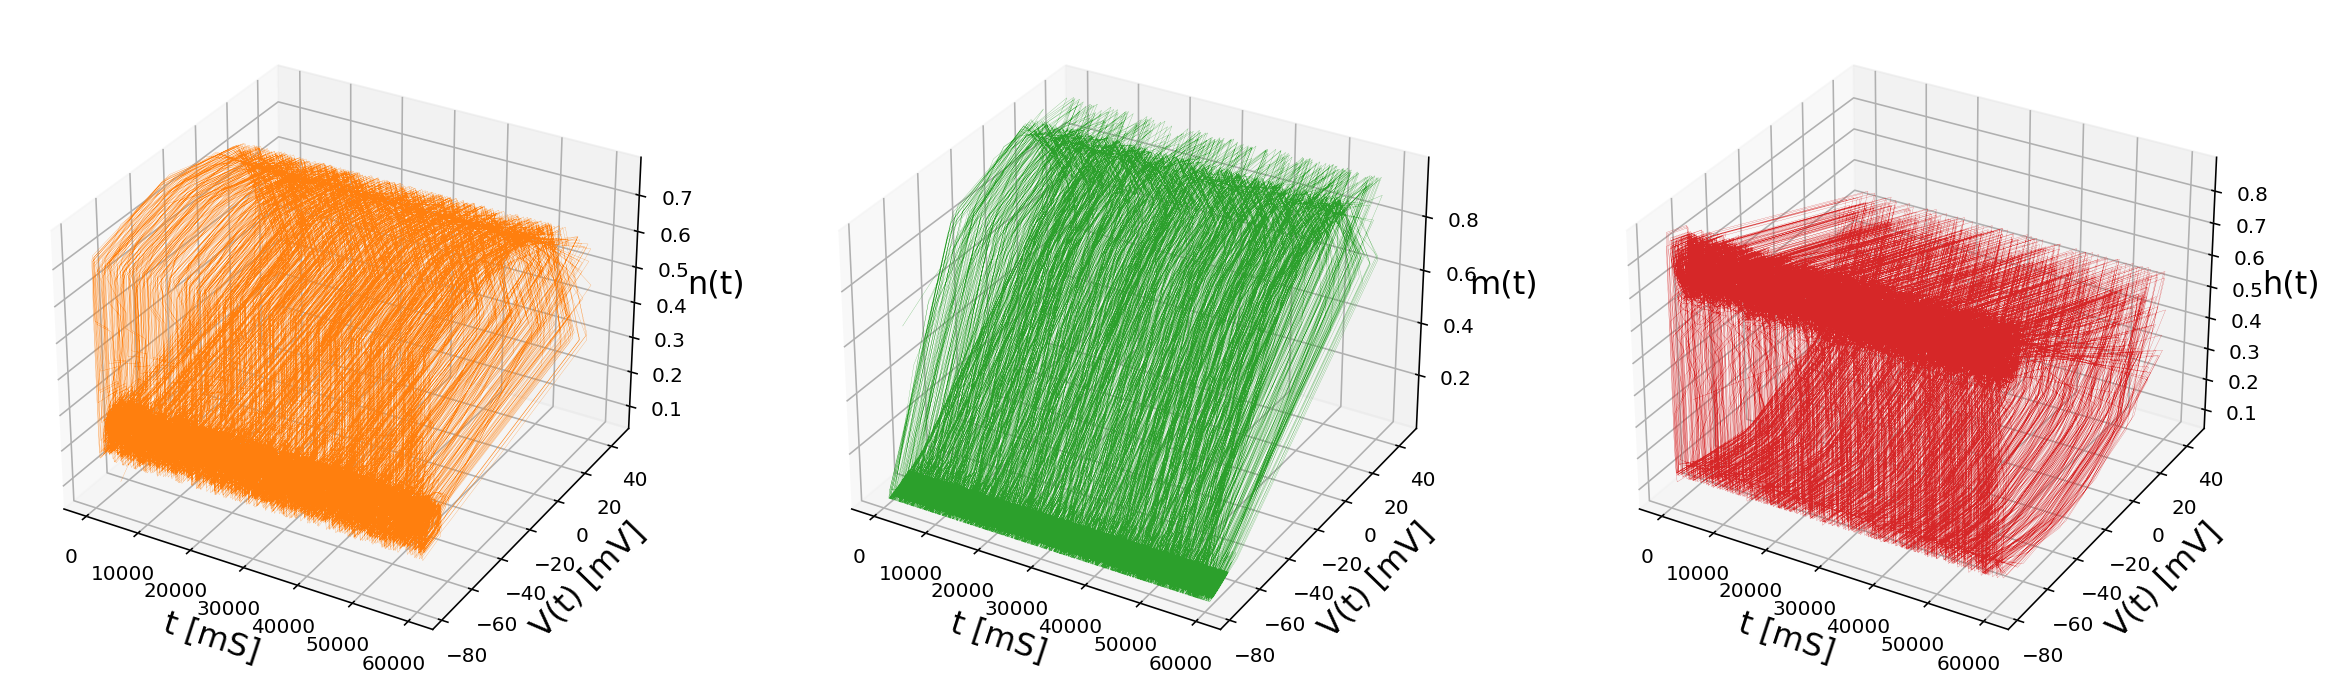

In [34]:
np.random.seed(9)
A = {'L_in':int(1e3), 'L_out':int(3.5e2), 'K_d': 1e9/128, 'gamma': 8, 'V_eq': -65, 'dist': lambda size: np.random.poisson(67, size=size), 'V': int(1e3), 'N': int(2e8)}
np.random.seed(9)
B = {'L_in':int(1e3), 'L_out':int(1.75e2), 'K_d': 1e9/500, 'gamma': 10, 'V_eq': 55, 'dist': lambda size: np.random.randint(40, size=size), 'V': int(9.65e2), 'N': int(1e9)}

t_max= 60*int(1e3)
t = np.arange(0, t_max, 1)

XXX = Hodgkin_Huxley_Model(t)
solution = XXX.solve_system()
visulize_simulation(solution, t)

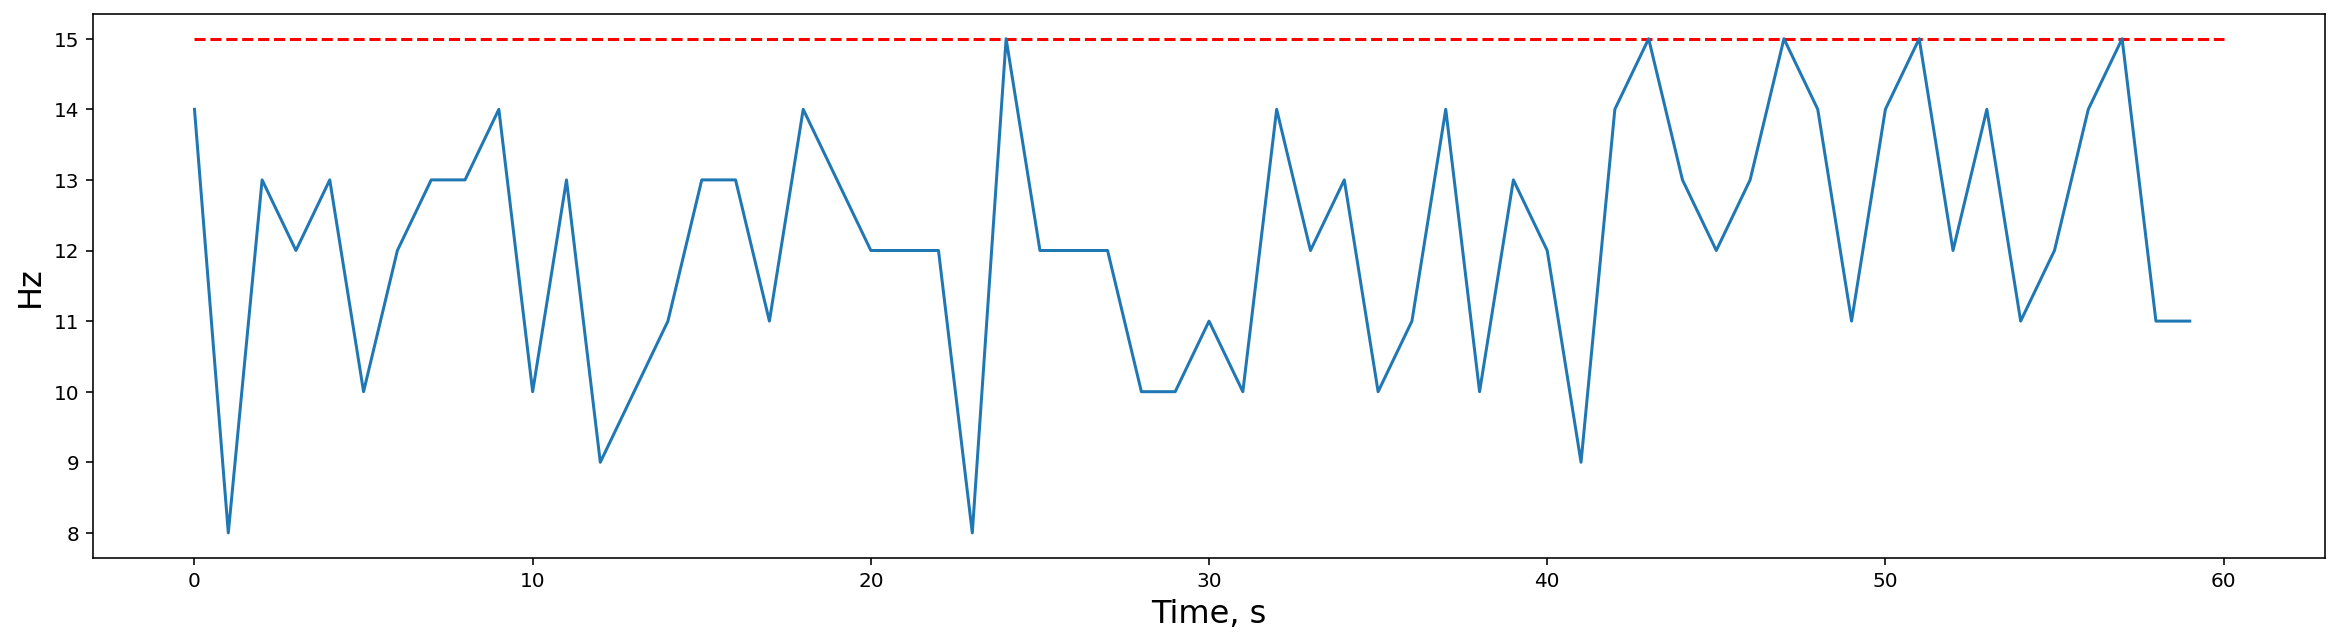

In [36]:
hz = to_HZ(solution)
visulize_burst(hz, th=15)

Получили бёрстинговой активности нейрона (частота не менее 15Гц) не менее 3 раз за время эксперимента